In [6]:
import matplotlib.pyplot as plt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # path fo is_list_like has been changed
from pandas_datareader import data
import numpy as np
import h5py
import datetime
import os, sys

sys.path.append("../")
from src.data import get_raw_stock_price_data 

data_path = '../data/raw/'

# Arguements
path = '../data/raw/'
freq = 'daily'  # 'daily', 'weekly', or 'monthly'
start_date = '2007-10-01'
end_date = '2017-09-29'
sort_by_date_ascending = True

ticker_in_raw = os.listdir(data_path)

ticker_list_input = ['AAPL', 'PG', 'UL', 'FB', 'NVDA',
               'QCOM', 'TSLA', 'EBAY', 'CSCO', 'BIDU',
               'GOOGL']

ticker_list_input = ['AAPL', 'PG', 'UL', 'INTC', 'NVDA',
                     'QCOM', 'MSFT', 'EBAY', 'CSCO', 'BIDU',
                     'GOOGL']
# check if stock data exist

ticker_list = []

for ticker in ticker_list_input:
    print("working on", ticker)
    if ticker+'.h5' in ticker_in_raw:
        if check_data_avaliability(path+ticker+'.h5' , start_date, end_date, freq, sort_by_date_ascending) == True:
            ticker_list.append(data_path + ticker+'.h5')
        else:
            get_raw_stock_price_data.update_price_data(path, ticker, start_date, end_date)
    else:
        print(ticker, "is not in raw data folder")
        get_raw_stock_price_data.download_price_data(path, ticker, freq, start_date, end_date, sort_by_date_ascending)
        ticker_list.append(data_path + ticker+'.h5')

working on AAPL
working on PG
working on UL
working on INTC
INTC is not in raw data folder
The downloaded price data has shape(2518, 8)
INTC's price data is saved.
working on NVDA
working on QCOM
working on MSFT
MSFT is not in raw data folder
The downloaded price data has shape(2518, 8)
MSFT's price data is saved.
working on EBAY
working on CSCO
working on BIDU
working on GOOGL


In [7]:
ticker_list

['../data/raw/AAPL.h5',
 '../data/raw/PG.h5',
 '../data/raw/UL.h5',
 '../data/raw/INTC.h5',
 '../data/raw/NVDA.h5',
 '../data/raw/QCOM.h5',
 '../data/raw/MSFT.h5',
 '../data/raw/EBAY.h5',
 '../data/raw/CSCO.h5',
 '../data/raw/BIDU.h5',
 '../data/raw/GOOGL.h5']

In [26]:
def check_data_avaliability(h5_file, start_date, end_date, freq, sort_by_date_ascending):
    start_date_h5  = datetime.datetime.strptime(pd.read_hdf(h5_file, 'start_date').iloc[-1], '%Y-%m-%d')
    end_date_h5  = datetime.datetime.strptime(pd.read_hdf(h5_file, 'end_date').iloc[-1], '%Y-%m-%d')
    freq_h5 = pd.read_hdf(h5_file, key='freq')
    sort_by_date_ascending_h5 = pd.read_hdf(h5_file, key='sort_by_date_ascending')
    error = False
    if start_date_h5 > datetime.datetime.strptime(start_date, '%Y-%m-%d'):
        print('start date does not match')
        error = True
    
    if end_date_h5 < datetime.datetime.strptime(end_date, '%Y-%m-%d'):
        print('end date does not match')
        error = True
        
    if freq_h5.item() != freq:
        print('freq does not match')
        error = True
    
    if sort_by_date_ascending_h5.item() != sort_by_date_ascending:
        print('sort_by_date_ascending does not match')
        error = True
        
    if error:
        return False
    else:
        return True
    
datelist = pd.Series(pd.date_range(start_date, end_date)).apply(lambda x: str(x)[:10])
date_pd = pd.DataFrame({'formatted_date' : datelist})

open_df = date_pd
high_df = date_pd
low_df = date_pd
close_df = date_pd

for ticker_path in ticker_list:
    if check_data_avaliability(ticker_path, start_date, end_date, freq, sort_by_date_ascending) == False:
        print(ticker_path, 'is not complete for this request')
    ticker_name = ticker_path.replace('.h5','').replace(data_path, '')
    price_df = pd.read_hdf(ticker_path,key='df')
    
    open_df = pd.merge(open_df, price_df[['open', 'formatted_date']], on='formatted_date', how='left')
    open_df.rename(columns={'open': ticker_name}, inplace=True)
    
    high_df = pd.merge(high_df, price_df[['high', 'formatted_date']], on='formatted_date', how='left')
    high_df.rename(columns={'high': ticker_name}, inplace=True)

    low_df = pd.merge(low_df, price_df[['low', 'formatted_date']], on='formatted_date', how='left')
    low_df.rename(columns={'low': ticker_name}, inplace=True)

    close_df = pd.merge(close_df, price_df[['close', 'formatted_date']], on='formatted_date', how='left')
    close_df.rename(columns={'close': ticker_name}, inplace=True)

open_df.fillna(0, inplace=True)
high_df.fillna(0, inplace=True)
low_df.fillna(0, inplace=True)
close_df.fillna(0, inplace=True)

open_df = open_df[open_df.sum(axis=1) != 0]
high_df = high_df[high_df.sum(axis=1) != 0]
low_df = low_df[low_df.sum(axis=1) != 0]
close_df = close_df[close_df.sum(axis=1) != 0]

open_np = np.array(open_df.iloc[:,1:])
high_np = np.array(high_df.iloc[:,1:])
low_np = np.array(low_df.iloc[:,1:])
close_np = np.array(close_df.iloc[:,1:])
result_np = np.stack([open_np, high_np, low_np, close_np], axis=0)


print('The resulting data has shape', str(result_np.shape)+',',
      'and has', result_np.size -  np.count_nonzero(result_np), 'missing data.')

print(np.mean(result_np[0,:,:] == open_np), 
      np.mean(result_np[1,:,:] == high_np), 
      np.mean(result_np[2,:,:] == low_np),
      np.mean(result_np[3,:,:] == close_np))

The resulting data has shape (4, 2519, 11), and has 8 missing data.
1.0 1.0 1.0 1.0


In [18]:
result_np.shape

2534

In [34]:
open_df.columns == high_df.columns
low_df.columns == close_df.columns
open_df.columns[1:] == [ticker_path.replace('.h5','').replace(data_path, '') for ticker_path in ticker_list]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

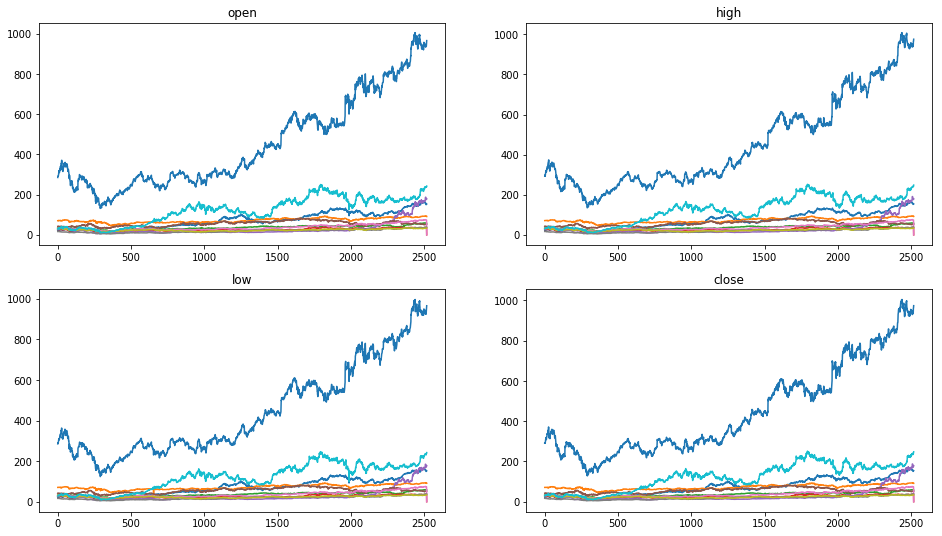

In [35]:
f = plt.figure(figsize=(16,9))
plt.tight_layout()

f.add_subplot(221)
plt.plot(result_np[0,:,:])
plt.title('open')

f.add_subplot(222)
plt.plot(result_np[1,:,:])
plt.title('high')

f.add_subplot(223)
plt.plot(result_np[2,:,:])
plt.title('low')

f.add_subplot(224)
plt.plot(result_np[3,:,:])
plt.title('close')

plt.show()

array([[ 22.09000015,  29.20299911,  33.00999832, ...,  42.04999924,
          0.        ,  31.68000031],
       [ 22.36428642,  30.02599907,  33.        , ...,  42.09000015,
          0.        ,  31.92000008],
       [ 22.54000092,  31.88400078,  32.90000153, ...,  41.72999954,
          0.        ,  31.29000092],
       ...,
       [153.80000305, 240.02000427,  33.77999878, ...,  51.43000031,
        349.8999939 ,  56.95000076],
       [153.88999939, 238.47000122,  33.22000122, ...,  51.38000107,
        339.88000488,  57.04000092],
       [153.21000671, 242.02999878,  33.31000137, ...,  51.90999985,
        341.85998535,  57.83000183]])

In [62]:
a = pd.read_hdf(ticker_list[0], key='freq')
a.item()

'daily'

In [176]:
print(start_date)

for ticker_path in ticker_list:
    if check_data_consistency(ticker_path, start_date, end_date, freq, sort_by_date_ascending):
        print('ok')
        price_df = pd.read_hdf(ticker_path,key='df')
        start_row = price_df.loc[price_df['formatted_date'] == start_date].index.item()
        end_row = price_df.loc[price_df['formatted_date'] == end_date].index.item()
        price_df = price_df[['open','high', 'low', 'close', 'formatted_date']]
        print(start_row, end_row)
    else:
        break

2007-10-01
ok
0 2518
ok
0 2518
ok
0 2518
ok
0 2518
start date does not match


,formatted_date
0,2007-10-01
1,2007-10-02
2,2007-10-03
3,2007-10-04
4,2007-10-05
5,2007-10-06
6,2007-10-07
7,2007-10-08
8,2007-10-09
9,2007-10-10


start date does not match
../data/raw/FB.h5 is not complete for the request
start date does not match
../data/raw/TSLA.h5 is not complete for the request


In [207]:
# date_pd.merge(price_df, on='formatted_date')
open_df

,formatted_date,open_x,open_y,open_x,open_y,open_x,open_y,open_x,open_y,open_x,open_y,open
0,2007-10-01,22.090000,29.202999,33.009998,16.418350,NaN,285.270264,36.549999,70.440002,42.049999,NaN,31.680000
1,2007-10-02,22.364286,30.025999,33.000000,16.679293,NaN,291.981995,37.680000,70.849998,42.090000,NaN,31.920000
2,2007-10-03,22.540001,31.884001,32.900002,16.498316,NaN,293.418427,36.750000,70.720001,41.730000,NaN,31.290001
3,2007-10-04,22.571428,30.972000,32.590000,16.481482,NaN,292.837830,35.779999,70.199997,42.310001,NaN,31.180000
4,2007-10-05,22.624287,32.167000,32.340000,16.523569,NaN,293.848846,36.549999,70.900002,43.139999,NaN,31.910000
5,2007-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2007-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2007-10-08,23.355715,32.438999,32.529999,16.296297,NaN,297.797791,37.189999,70.050003,42.959999,NaN,31.809999
8,2007-10-09,24.314285,32.998001,32.799999,16.123737,NaN,307.862854,37.529999,71.180000,42.779999,NaN,31.809999
9,2007-10-10,23.935715,32.799999,33.389999,16.481482,NaN,310.990997,37.119999,71.150002,42.619999,NaN,32.189999


In [131]:
price_df
print(ticker_path, start_date)
print(price_df.loc[price_df['formatted_date'] == start_date])
# start_row = price_df.loc[price_df['formatted_date'] == start_date]#.index.item()
# start_row

../data/raw/FB.h5 2007-10-01
Empty DataFrame
Columns: [adjclose, close, date, formatted_date, high, low, open, volume]
Index: []


In [144]:
print(pd.read_hdf(ticker_path, key='start_date').item())
print(ticker_path)

2007-10-01
../data/raw/FB.h5


In [150]:
(price_df['formatted_date'])

0       2012-05-18
1       2012-05-21
2       2012-05-22
3       2012-05-23
4       2012-05-24
5       2012-05-25
6       2012-05-29
7       2012-05-30
8       2012-05-31
9       2012-06-01
10      2012-06-04
11      2012-06-05
12      2012-06-06
13      2012-06-07
14      2012-06-08
15      2012-06-11
16      2012-06-12
17      2012-06-13
18      2012-06-14
19      2012-06-15
20      2012-06-18
21      2012-06-19
22      2012-06-20
23      2012-06-21
24      2012-06-22
25      2012-06-25
26      2012-06-26
27      2012-06-27
28      2012-06-28
29      2012-06-29
           ...    
1321    2017-08-18
1322    2017-08-21
1323    2017-08-22
1324    2017-08-23
1325    2017-08-24
1326    2017-08-25
1327    2017-08-28
1328    2017-08-29
1329    2017-08-30
1330    2017-08-31
1331    2017-09-01
1332    2017-09-05
1333    2017-09-06
1334    2017-09-07
1335    2017-09-08
1336    2017-09-11
1337    2017-09-12
1338    2017-09-13
1339    2017-09-14
1340    2017-09-15
1341    2017-09-18
1342    2017